In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict
import ipywidgets as widgets
from collections import defaultdict

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
artifacts_dir = "/etc/skel/sandmark-nightly/sequential/"

In [3]:
bench_files = []

artifacts_path = artifacts_dir.split("/sequential/")[0]

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith("_1.orun.summary.bench"):
            f = root.split("/sequential/")
            bench_files.append((os.path.join(root, file)))

In [40]:
def files_to_dict(files):
    benches = defaultdict(list)
    for x in files:
        l = x.split("/sequential/")[1]
        d = l.split("/")
        timestamp    = d[0]
        commit       = d[1]
        variant      = d[2]
        variant_root = d[2].split('_')[0]
        variant_stem = d[2].split('_')[1]
        value        = variant_root + '+' + commit + '_' + variant_stem
        benches[timestamp].append(value)
    benches = dict(benches)
    return benches

benches = files_to_dict(bench_files)

In [41]:
def f(x): return x

def disp(benches):
    
    def select_commit(timestamp):
        variantW.options = benches[timestamp]
    
    def do_nothing(variant):
        pass
    
    timestamp_list = sorted(list(benches.keys()), reverse=True)
    timestampW = widgets.Dropdown(options=timestamp_list, description='Timestamp', disabled=False)
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    variantW = widgets.Dropdown(options=benches[timestampW.value], description='Variant', disabled=False)
    variantD = widgets.interactive(do_nothing, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       width='100%')
    items = [timestampD, variantD]
    box = Box(children=items, layout=box_layout)
    display(box)
    return (timestampD, variantD)

def get_filename(t, v):
    timestamp = t.children[0].value
    commit_id = v.children[0].value.split('_')[0].split('+')[-1]
    variant   = v.children[0].value.split('_')[0].split('+')
    variant.pop()
    variant   = '+'.join(variant) + '_' + v.children[0].value.split('_')[1]
    filename  = os.path.join(
        artifacts_path, 
        "sequential", 
        timestamp,
        commit_id,
        variant
        )
    return filename

In [42]:
comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [79]:
print(comparisons.result)

2


In [80]:
matrix = [[0 for x in range(3)] for y in range(comparisons.result)]  
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210611_000002', '20210610_00…

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210611_000002', '20210610_00…

In [81]:
for i in range(comparisons.result):
    matrix[i][2] = get_filename(matrix[i][0], matrix[i][1])

In [82]:
selected_files = []
for i in range (comparisons.result):
    selected_files.append(matrix[i][2])

In [83]:
data_frames = []

for file in selected_files:
    with open(file) as f:
#         print(f)
        data = []
        for l in f:
#             print(type(l))
            data.append(json.loads(l))
#         print(data[1]['name'])
        df = pdjson.json_normalize(data)
        value     = file.split('/sequential/')[1]
        date      = value.split('/')[0].split('_')[0]
        commit_id = value.split('/')[1][:7]
        variant   = value.split('/')[2].split('_')[0]
        df["variant"] = variant + '_' + date + '_' + commit_id
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name']) 
# Uncomment the following to display all the lines in pandas output
# pd.set_option('display.max_rows', df.shape[0]+1)

<ipython-input-83-2d05a83fddec>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pdjson.json_normalize(data)


In [84]:
df = df[(df.name != 'alt-ergo.fill.why') &         #multicore version does not exist
        (df.name != 'alt-ergo.yyll.why') &         #multicore version does not exist
        (df.name != 'frama-c.slevel') &            #multicore version does not exist
        (df.name != 'js_of_ocaml.frama-c_byte')]   #multicore version does not exist
throughput_df = df

In [85]:
selected_baselines = files_to_dict(selected_files)
baseline_t, baseline_v = disp(selected_baselines)

Box(children=(interactive(children=(Dropdown(description='Timestamp', options=('20210611_000002',), value='202…

In [86]:
selected_baseline = ""
date      = baseline_t.children[0].value.split('_')[0]
commit_id = baseline_v.children[0].value.split('_')[0].split('+')[-1][:7]
variant   = baseline_v.children[0].value.split('_')[0].split('+')
variant.pop()
variant   = "+".join(variant)
value     = variant + '_' + date + '_' + commit_id
selected_baseline = value

print(selected_baseline)

4.12.0+stock_20210611_7e6b22b


## Time

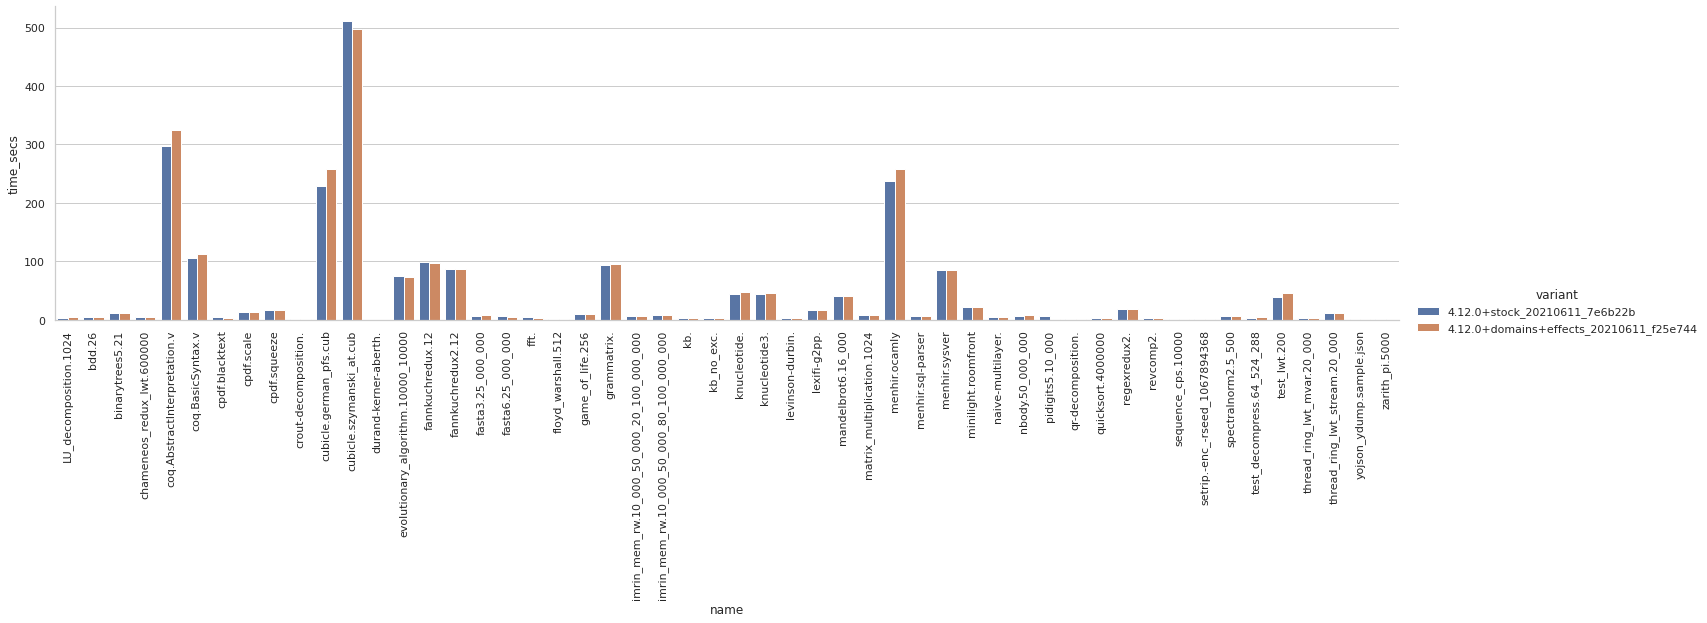

In [87]:
g = sns.catplot (x='name', y='time_secs', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalized

In [88]:
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
    variant_metric_name = list([ zip(df[metric], df[x], df['name'])
            for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
        (v,data) = group
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
            df = pd.concat(ndata_frames)
            return df
        else:
            print("The selected baseline variant is equal to the other variants\n" 
                  + "Update the dropdowns with different varians to plot normalisation graphs\n")
            return None

def plot_normalised(df,variant,topic):
    if df is not None:
        df = pd.DataFrame.copy(df)
        df.sort_values(by=[topic],inplace=True)
        df[topic] = df[topic] - 1
        g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
        g.set_xticklabels(rotation=90)
        g.ax.legend(loc=8)
        g._legend.remove()
        g.ax.set_xlabel("Benchmarks")
        return g
        # g.ax.set_yscale('log')
    else:
        print("ndf is equal to None, possibly due to variants being equal to the baseline variant\n")

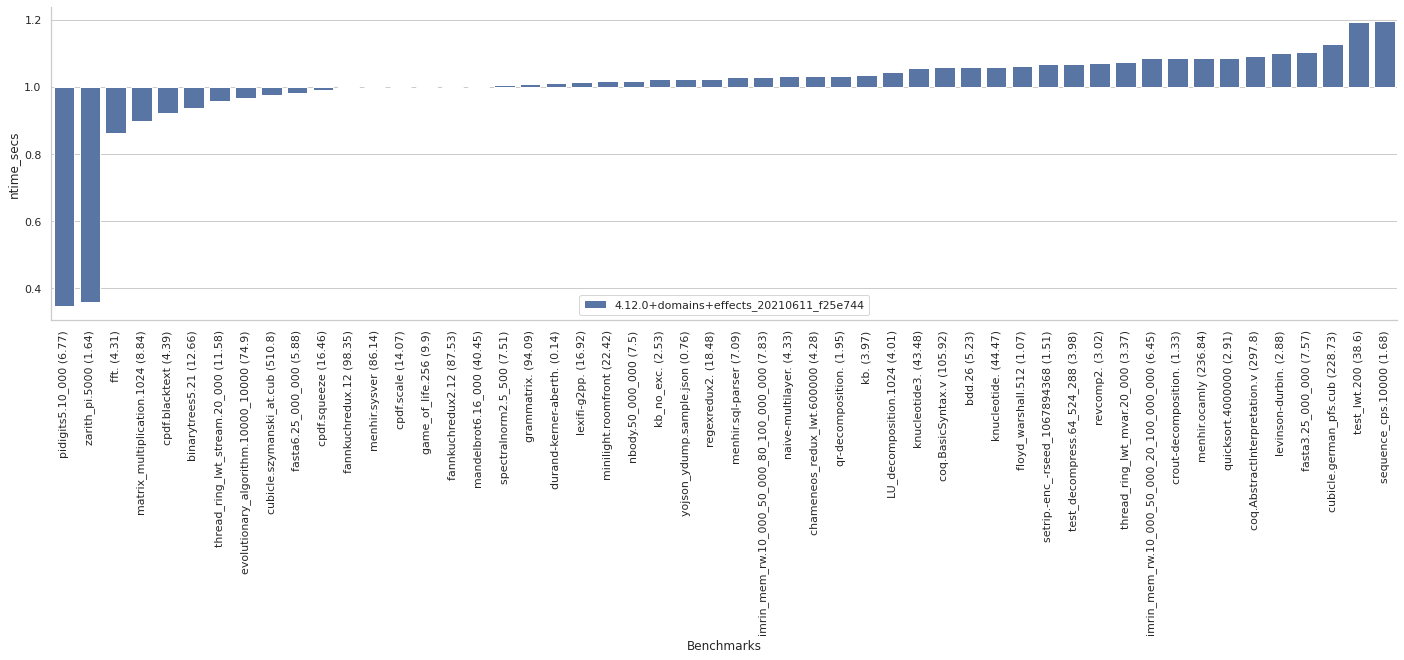

In [89]:
ndf = normalise(df, selected_baseline,'time_secs')
plot_normalised(ndf, selected_baseline,'ntime_secs')

## Top heap words

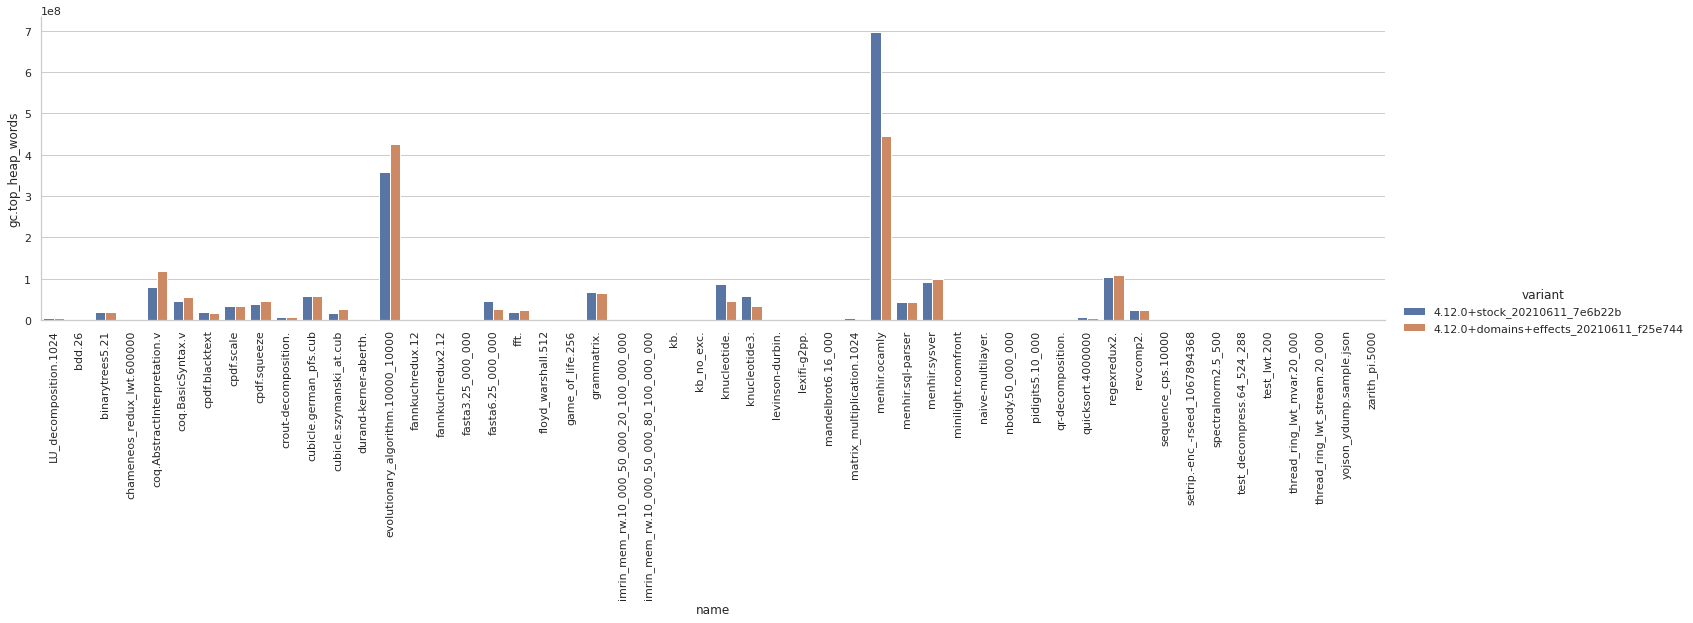

In [90]:
g = sns.catplot (x='name', y='gc.top_heap_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

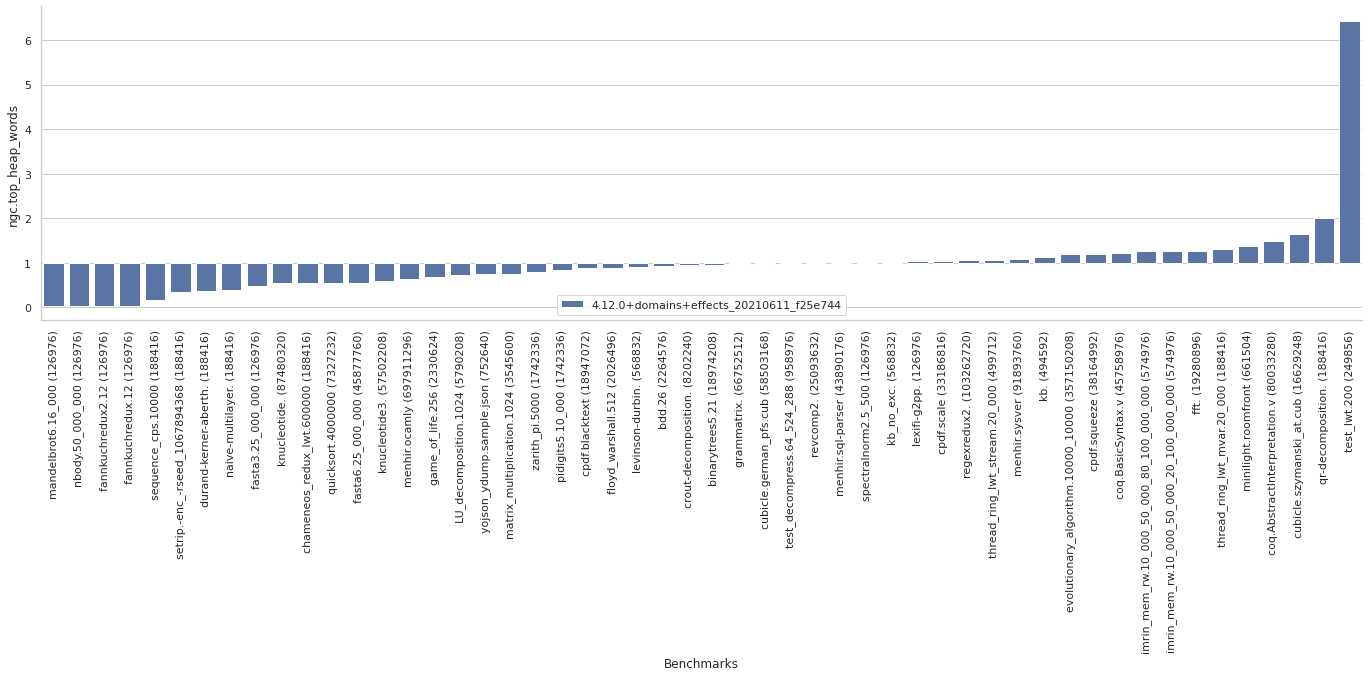

In [91]:
ndf = normalise(df,selected_baseline,'gc.top_heap_words')
plot_normalised(ndf,selected_baseline,'ngc.top_heap_words')

## Max RSS (KB)

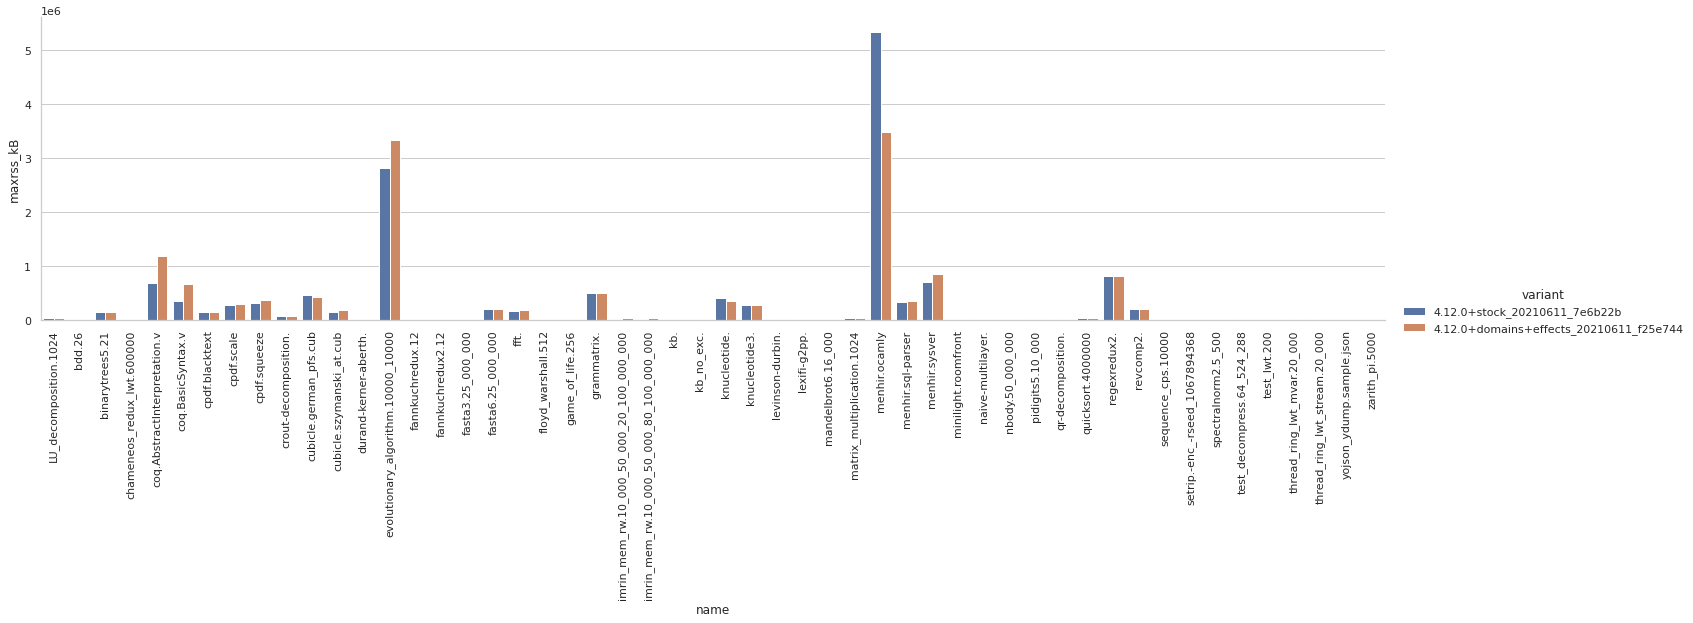

In [92]:
g = sns.catplot (x='name', y='maxrss_kB', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

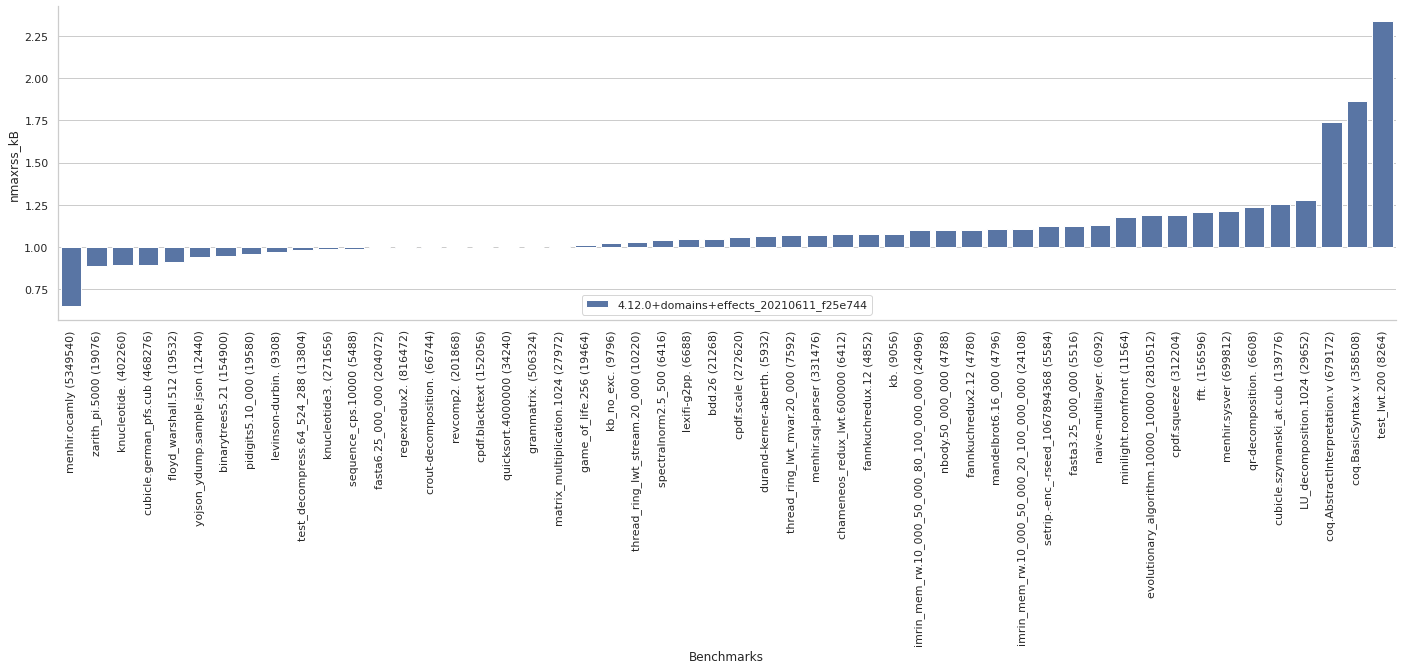

In [93]:
ndf = normalise(df,selected_baseline,'maxrss_kB')
plot_normalised(ndf,selected_baseline,'nmaxrss_kB')

## Major Collections

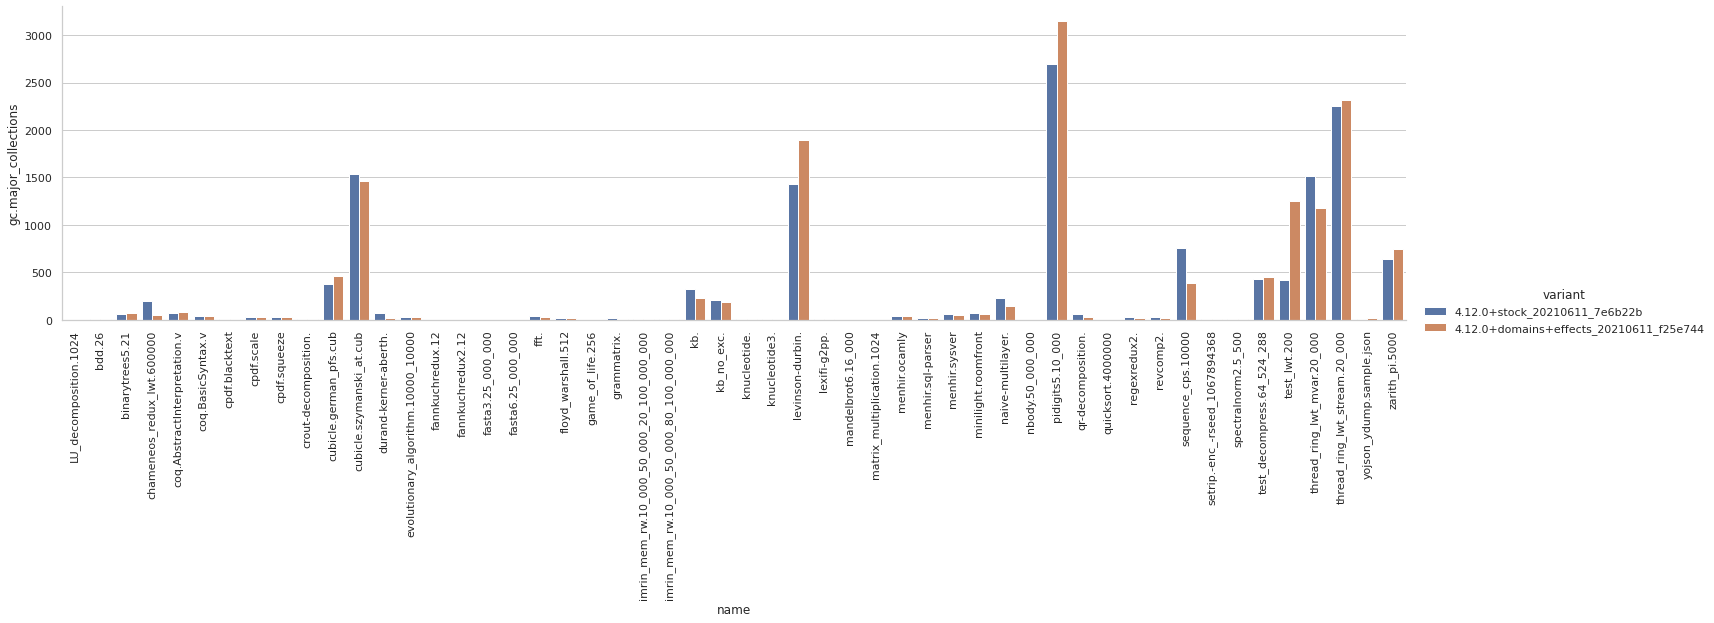

In [94]:
g = sns.catplot (x='name', y='gc.major_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

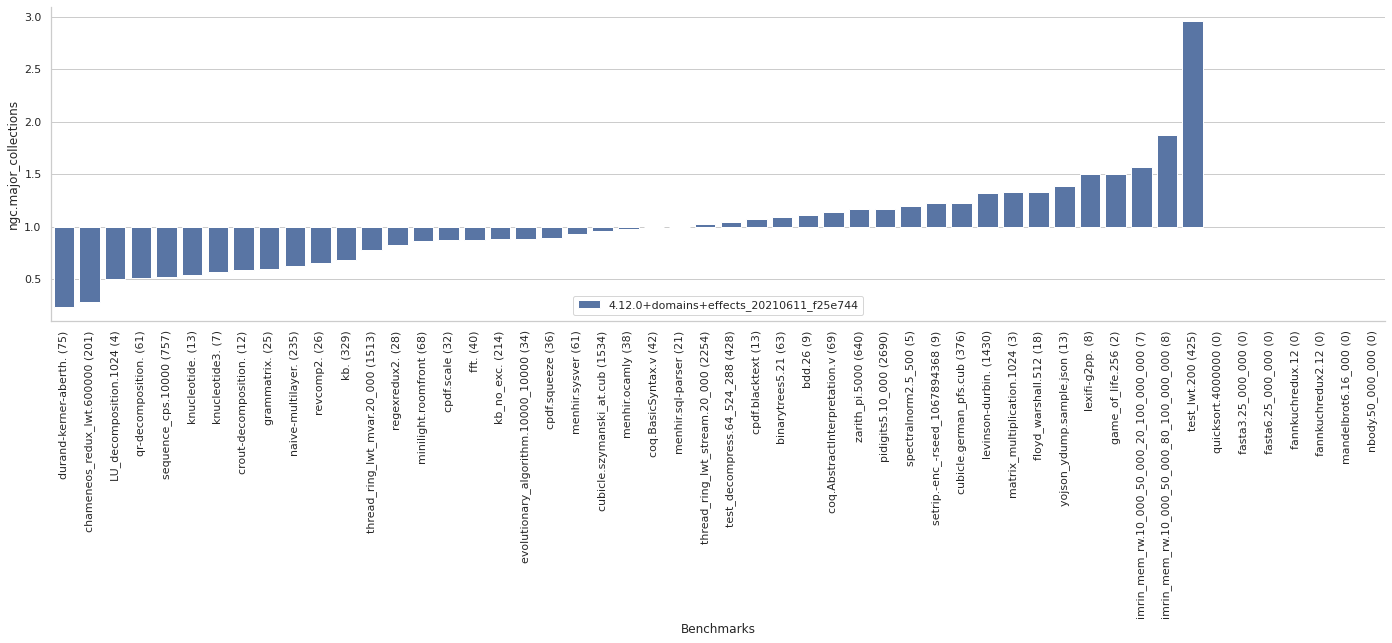

In [95]:
ndf = normalise(df,selected_baseline,'gc.major_collections')
plot_normalised(ndf,selected_baseline,'ngc.major_collections')

## Major words

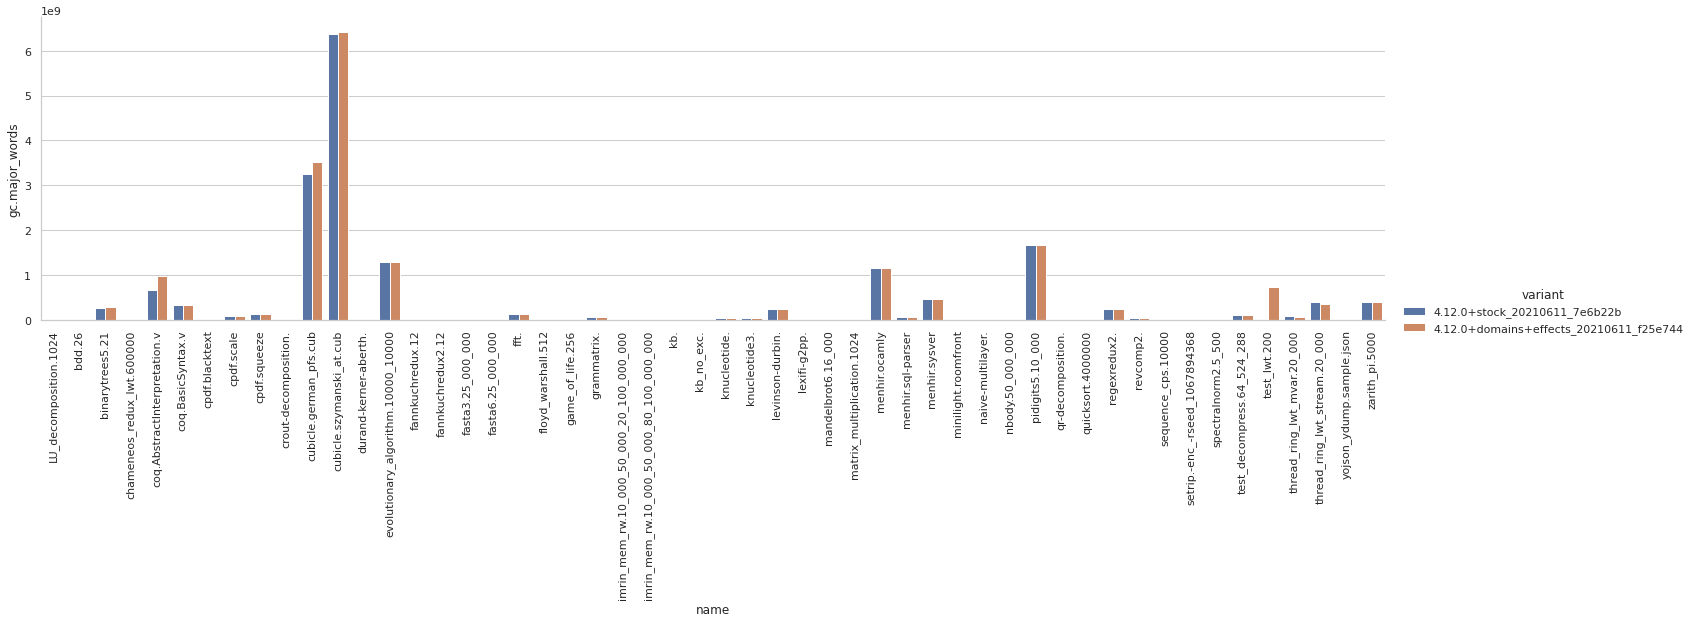

In [96]:
g = sns.catplot (x='name', y='gc.major_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

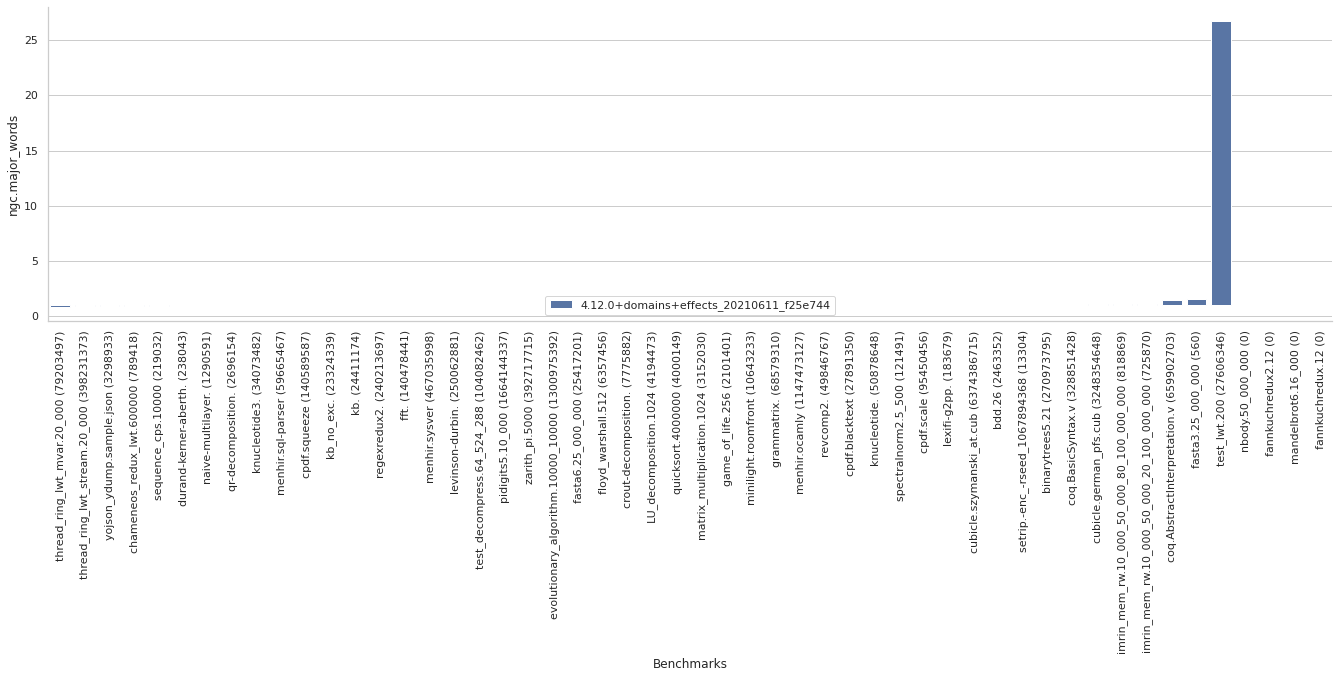

In [97]:
ndf = normalise(df,selected_baseline,'gc.major_words')
plot_normalised(ndf,selected_baseline,'ngc.major_words')

## Minor Collections

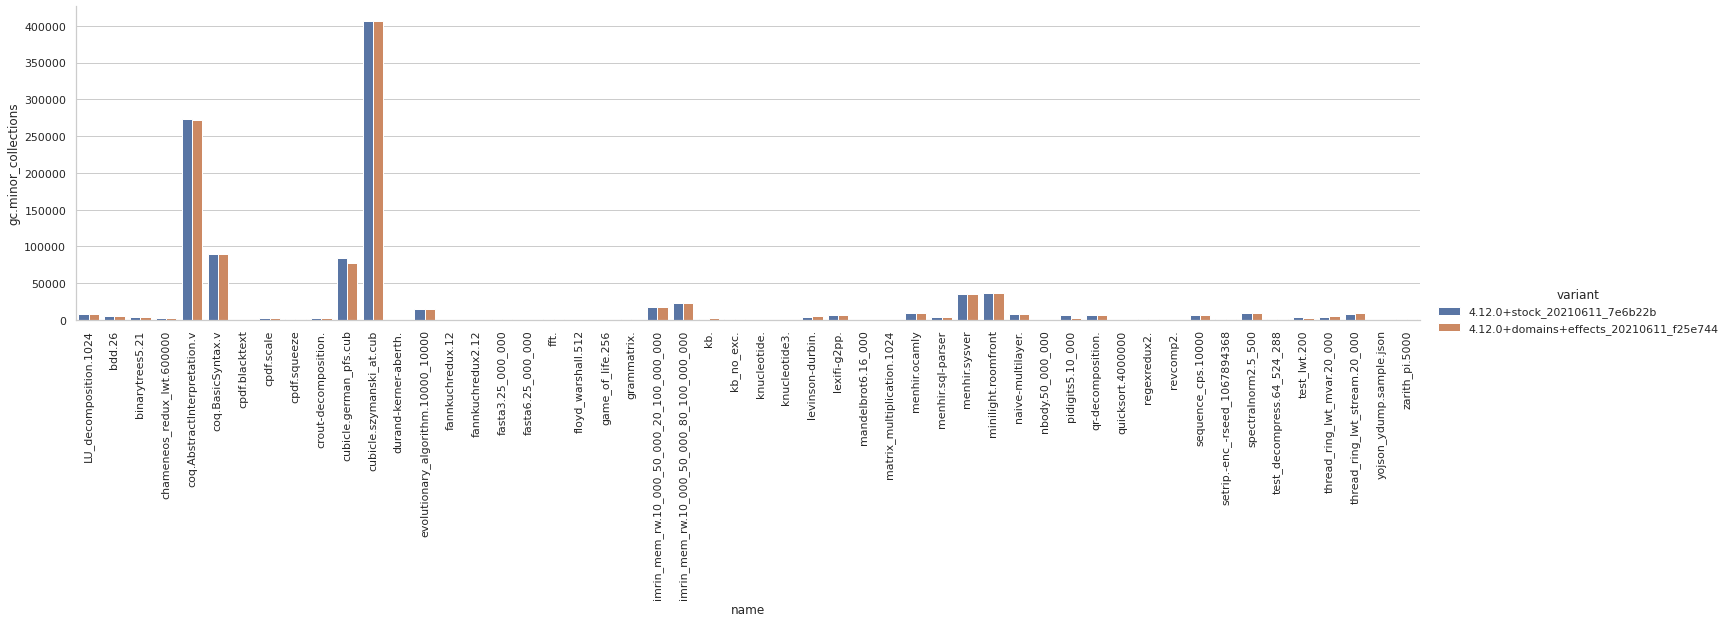

In [98]:
g = sns.catplot (x='name', y='gc.minor_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

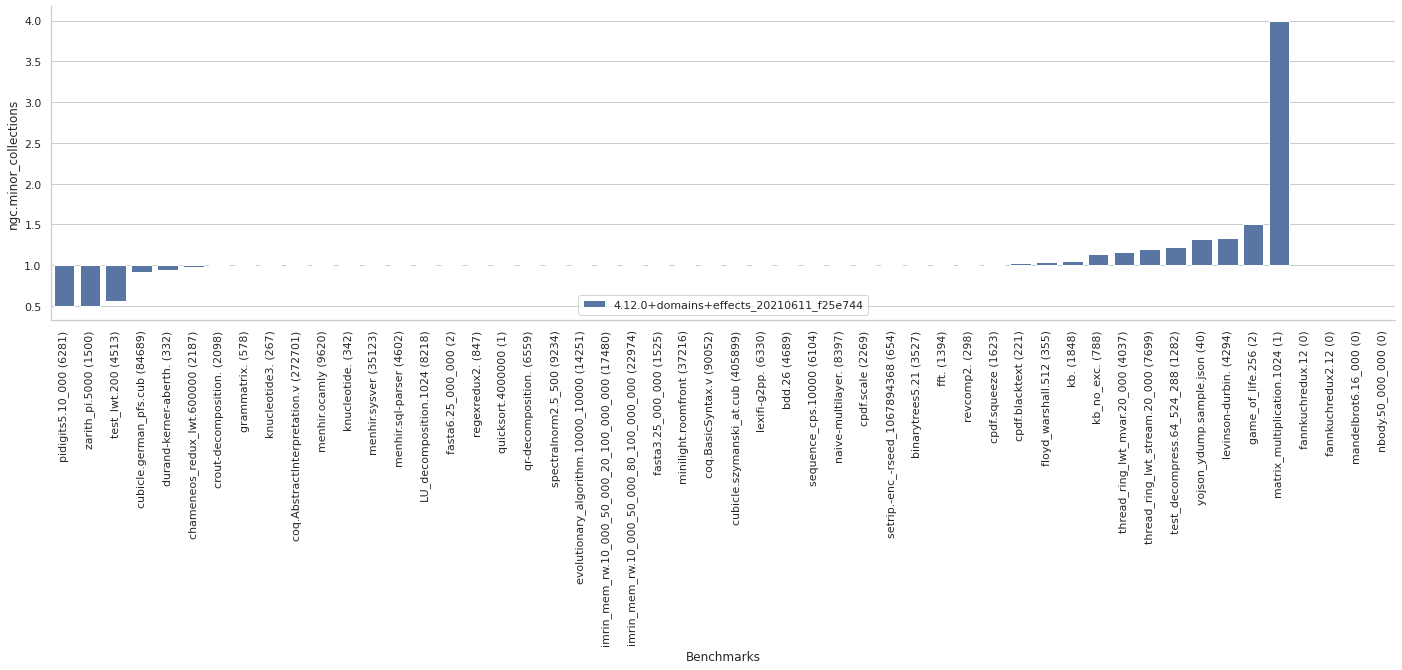

In [99]:
ndf = normalise(df,selected_baseline,'gc.minor_collections')
plot_normalised(ndf,selected_baseline,'ngc.minor_collections')